In [23]:
import pandas as pd
# Load Data
url = 'https://raw.githubusercontent.com/SEAnalytics/datasets/master/storypoint/IEEE%20TSE2018/dataset/mulestudio.csv'
raw_data = pd.read_csv(url)
raw_data.columns
raw_data.head(6)

,issuekey,title,description,storypoint
0,STUDIO-95,Support for request/reply,request/reply http://www.mulesoft.org/documen...,13
1,STUDIO-280,Cannot import a Studio project from Git withou...,Steps to reproduce: 1. Create a simple Mule...,3
2,STUDIO-382,Changes to Java code do not get hot deployed,Java source changes don't get picked up right ...,5
3,STUDIO-459,Unable to add a response when creating a secon...,Unable to add a response when creating a secon...,8
4,STUDIO-618,Namespaces in the XML view are not being remo...,When you add an element and then you remove it...,8
5,STUDIO-781,Would save time to be given the option to crea...,Add a button in the ClassFieldEditor to create...,5


In [24]:
# Check for missing values
raw_data.isnull().sum()


issuekey       0
title          0
description    0
storypoint     0
dtype: int64

In [25]:

# Examine storypoints summary statistics
raw_data.storypoint.describe()

count    732.000000
mean       6.396175
std        5.385687
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       34.000000
Name: storypoint, dtype: float64

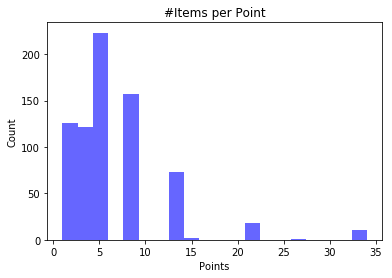

In [26]:
# Visualize number of storypoints distribution
import matplotlib.pyplot as plt
plt.hist(raw_data.storypoint, bins=20, alpha=0.6, color='b')
plt.title("#Items per Point")
plt.xlabel("Points")
plt.ylabel("Count")
plt.show()


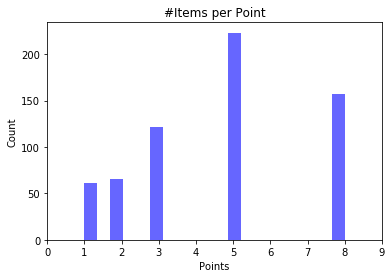

In [27]:
# Zoom in on most common data representing 75% of the dataset
import numpy as np
frequent_data = raw_data.query('storypoint <= 8')
plt.hist(frequent_data.storypoint, bins=20, alpha=0.6, color='b')
plt.title("#Items per Point")
plt.xlabel("Points")
plt.ylabel("Count")
plt.xticks(np.arange(0, 10, 1)) 
plt.show()

In [28]:
# Examine distribution in detail
raw_data.groupby('storypoint').size()

storypoint
1      61
2      65
3     121
5     223
8     157
13     73
15      2
21     18
26      1
34     11
dtype: int64

In [29]:

raw_data.loc[raw_data.storypoint <= 2, 'storypoint'] = 0 #small
raw_data.loc[(raw_data.storypoint > 2) & (raw_data.storypoint <= 5), 'storypoint'] = 1 #medium
raw_data.loc[raw_data.storypoint > 5, 'storypoint'] = 2 #big


In [30]:
# Examine distribution in detail
raw_data.groupby('storypoint').size()

storypoint
0    126
1    344
2    262
dtype: int64

This shows that 5 the most common number of storypoints assigned to an issue/requirement.

In [31]:
################### Data Preprocessing ###################################

import nltk
from nltk.corpus import stopwords 
nltk.download('punkt')
nltk.download('stopwords')

# Tokenize
raw_data['tokens'] = raw_data['description'].apply(lambda x : nltk.word_tokenize(x))

type(raw_data['description'][0])




[nltk_data] Downloading package punkt to /home/eliska/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/eliska/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


str

In [32]:
# Convert all words to lower case
raw_data['tokens'] = raw_data['tokens'].apply(lambda x : [w.lower() for w in x])

# Remove punctuation from each word
import string
table = str.maketrans('', '', string.punctuation)
raw_data['tokens'] = raw_data['tokens'].apply(lambda x: [w.translate(table) for w in x])

# Remove tokens that are not alphabetic
raw_data['tokens'] = raw_data['tokens'].apply(lambda x: [w for w in x if w.isalpha()])

# Remove stop words
stop_words = stopwords.words('english')
raw_data['tokens'] = raw_data['tokens'].apply(lambda x: [w for w in x if w not in stop_words])

raw_data['tokens'] = raw_data['tokens'].apply(lambda x: nltk.Text(x))

# Lemmatization
nltk.download('wordnet')
lemmatizer = nltk.WordNetLemmatizer()
raw_data['tokens'] = raw_data['tokens'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x ])

# Stemming
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
raw_data['tokens'] = raw_data['tokens'].apply(lambda x: [porter.stem(w) for w in x ])


raw_data

[nltk_data] Downloading package wordnet to /home/eliska/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,issuekey,title,description,storypoint,tokens
0,STUDIO-95,Support for request/reply,request/reply http://www.mulesoft.org/documen...,2,"[requestrepli, http, wwwmulesoftorgdocumentati..."
1,STUDIO-280,Cannot import a Studio project from Git withou...,Steps to reproduce: 1. Create a simple Mule...,1,"[step, reproduc, creat, simpl, mule, studio, p..."
2,STUDIO-382,Changes to Java code do not get hot deployed,Java source changes don't get picked up right ...,1,"[java, sourc, chang, nt, get, pick, right, aut..."
3,STUDIO-459,Unable to add a response when creating a secon...,Unable to add a response when creating a secon...,2,"[unabl, add, respons, creat, second, flow, ste..."
4,STUDIO-618,Namespaces in the XML view are not being remo...,When you add an element and then you remove it...,2,"[add, element, remov, refer, schema, file, rem..."
5,STUDIO-781,Would save time to be given the option to crea...,Add a button in the ClassFieldEditor to create...,1,"[add, button, classfieldeditor, creat, class, ..."
6,STUDIO-782,View the class code just by clicking on the cl...,"Currently, to view the class code (e.g., compo...",1,"[current, view, class, code, eg, compon, speci..."
7,STUDIO-837,Reference to the subflow get lost when changin...,Steps to reproduce: 1.- Create a project in ...,2,"[step, reproduc, creat, project, studio, flow,..."
8,STUDIO-853,Studio can be a lot smarter when handling logi...,it seems we could have a single filter element...,2,"[seem, could, singl, filter, element, flow, co..."
9,STUDIO-1212,Response section is not displayed,"My config is as follows: <flow name=""TicketFl...",1,"[config, follow, flow, name, doc, name, compos..."


In [33]:
# Vocabulary
vocabulary = set([item for sublist in list(raw_data['tokens']) for item in sublist]) # list of unique words
vocabulary_size = len(vocabulary)
vocabulary_size

2750

In [34]:
# Frequency distribution of words
all_words = [item for sublist in list(raw_data['tokens']) for item in sublist]
len(all_words)
from nltk.probability import FreqDist
fdist = FreqDist(all_words)


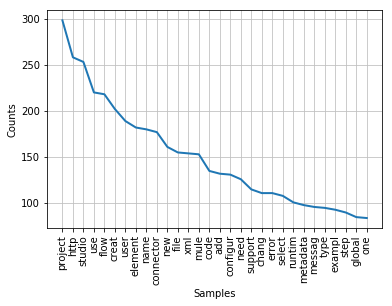

In [36]:
# Frequency Distribution of Words Plot
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()

In [70]:
# Remove html links
import re
for i in range (raw_data.shape[0]):
    #print(i)
    raw_data['description'][i] = re.sub(r'^https?:\/\/.*[\r\n]*', '', str(i), flags=re.MULTILINE)
    

/home/eliska/CS/VirtEnv/venv/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [71]:
# Split data into traning and testing
split_ratio = 0.7
total_number_of_datapoints = len(raw_data.index)
train_number_of_datapoints = int(total_number_of_datapoints * split_ratio)

train_set = raw_data.iloc[:train_number_of_datapoints, :]
test_set = raw_data.iloc[train_number_of_datapoints:, :]

Count Vectorization (One-Hot-Encoding)

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer

# Create our vectorizer
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(list(train_set['description']))

# Convert counts to frequencies
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(vectors)

# Build the classifier
clf = MultinomialNB(alpha=.01)

#  Train the classifier
clf.fit(X_train_tfidf, train_set['storypoint'].values)

# Get the test vectors
vectors_test = vectorizer.transform(list(test_set['description']))

# Predict and score the vectors
pred = clf.predict(vectors_test)
acc_score = metrics.accuracy_score( test_set['storypoint'].values, pred)
f1_score = metrics.f1_score( test_set['storypoint'].values, pred, average='macro')

print('Total accuracy classification score: {}'.format(acc_score))
print('Total F1 classification score: {}'.format(f1_score))


Total accuracy classification score: 0.45
Total F1 classification score: 0.20689655172413793


/home/eliska/CS/VirtEnv/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
